# RDKitでフィンガープリントを使った分子類似性の判定

In [1]:
import sys
print(sys.version)

3.7.3 | packaged by conda-forge | (default, Mar 27 2019, 23:01:00) 
[GCC 7.3.0]


In [2]:
import pandas as pd
from rdkit import rdBase, Chem, DataStructs
print(rdBase.rdkitVersion) # 2017.09.1
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import AllChem,Draw
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem.AtomPairs import Pairs, Torsions

2019.03.2


In [3]:
suppl = Chem.SDMolSupplier('../サリチル酸メチル.sdf',removeHs=False)
mols=[]
for x in suppl:
    if x is not None:
        mols.append(x)
len(mols)

73

## MACCS Keys
ケモインフォマティクスでは非常に有名なMDL社の開発した化学構造データベースに由来するフィンガープリントです．

全部で166の部分構造についての有無を調べ上げたもので，RDKit内の情報保持のために1ビット使っているため全部で167ビットのフィンガープリントになります．部分構造を有する場合は1が，ない場合は0が格納されています．

In [3]:
maccs_fps = [AllChem.GetMACCSKeysFingerprint(mol) for mol in mols]
maccs = DataStructs.BulkTanimotoSimilarity(maccs_fps[0], maccs_fps[1:])

## Topologicalフィンガープリント (RDKitフィンガープリント)  
ハッシュ化フィンガープリントの中では有名なDaylightフィンガープリントに類似したものと考えてよいです．RDKitフィンガープリントとも呼ばれています．

一定の結合数に相当する原子と結合種類を格納する方法で，事前に部分構造を用意する必要がないことから，より柔軟に分子構造を表現することが可能です．

In [4]:
rdkit_fps = [Chem.Fingerprints.FingerprintMols.FingerprintMol(mol) for mol in mols]
rdkit = DataStructs.BulkTanimotoSimilarity(rdkit_fps[0], rdkit_fps[1:])

## Morganフィンガープリント (Circularフィンガープリント) 
原子からある距離にある部分構造を数え上げていく，「circular substructures」と呼ばれるタイプのフィンガープリントです．radiusの値で距離を設定します．いわゆるECFP（Extended Connectivity Fingerprint）フィンガープリントと類似のものですが，探索距離の定義が異なる点に注意が必要です．

よく使われるECFP4はradius=2の設定（デフォルト）と大体同じとのことです．FCFP（Functional Connectivity Fingerprint）様のフィンガープリントを用いたい場合にはuseFeatures=Trueを設定します

![グラフ](./01ECFP.png)

In [5]:
morgan_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048) for mol in mols]
morgan = DataStructs.BulkTanimotoSimilarity(morgan_fps[0], morgan_fps[1:])

## Avalonフィンガープリント  
RDKitから用いることのできるAvalon Chemoinformatics TookKitにもフィンガープリントが実装されています．

In [6]:
avalon_fps = [pyAvalonTools.GetAvalonFP(mol) for mol in mols]
avalon = DataStructs.BulkTanimotoSimilarity(avalon_fps[0], avalon_fps[1:])

## アトムペアと二面角  
アトムペアを用いるフィンガープリントは全ての原子同士についてその最小結合パスを記録します．各原子には原子の種類，結合する原子のうち水素以外の元素の数，π電子数の情報も記録されます．

二面角を用いるフィンガープリントは，二面角を形成する4連続原子について，やはり原子の種類，結合する原子のうち水素以外の元素の数，π電子数を記録します．

## 各フィンガープリントの比較

In [7]:
df = pd.DataFrame({'RDKit': rdkit,
                  'Avalon': avalon,
                  'MACCS': maccs,
                  'Morgan': morgan})
df.corr().round(2)

,RDKit,Avalon,MACCS,Morgan
RDKit,1.00,0.88,0.64,0.79
Avalon,0.88,1.00,0.79,0.85
MACCS,0.64,0.79,1.00,0.68
Morgan,0.79,0.85,0.68,1.00


In [8]:
morgan_default = AllChem.GetMorganFingerprint(mols[0], 2)
morgan_bitvect = AllChem.GetMorganFingerprintAsBitVect(mols[0], 2, 2048)
print(morgan_default.GetLength(), morgan_bitvect.GetNumBits())

4294967295 2048


In [9]:
from IPython.display import SVG

In [10]:
### Morganフィンガープリント
bitI_morgan = {}
fp_morgan = AllChem.GetMorganFingerprintAsBitVect(mols[0], 2, bitInfo=bitI_morgan)
### RDKitフィンガープリント
bitI_rdkit = {}
fp_rdkit = Chem.RDKFingerprint(mols[0], bitInfo=bitI_rdkit)

In [11]:
for row in range(10):
    print(row)

0
1
2
3
4
5
6
7
8
9


In [62]:
bitI_rdkit.keys()

dict_keys([8, 23, 30, 35, 41, 44, 48, 50, 52, 62, 70, 74, 83, 90, 91, 92, 93, 96, 97, 103, 108, 115, 129, 138, 145, 150, 152, 161, 162, 163, 170, 173, 194, 196, 197, 202, 205, 206, 208, 209, 214, 215, 216, 225, 233, 235, 242, 243, 247, 261, 269, 277, 282, 285, 294, 296, 304, 313, 319, 326, 330, 331, 335, 342, 344, 346, 362, 366, 371, 385, 388, 390, 396, 403, 407, 413, 424, 427, 432, 435, 437, 438, 441, 443, 445, 447, 455, 461, 469, 471, 473, 477, 479, 482, 483, 501, 502, 506, 508, 513, 522, 523, 537, 549, 559, 561, 562, 563, 571, 581, 588, 589, 596, 598, 599, 601, 605, 608, 611, 620, 631, 644, 647, 648, 650, 655, 657, 658, 676, 686, 694, 698, 704, 720, 723, 735, 738, 739, 744, 748, 749, 756, 759, 760, 765, 766, 778, 779, 781, 784, 792, 794, 796, 806, 823, 830, 834, 837, 842, 849, 854, 855, 867, 868, 872, 883, 893, 909, 911, 914, 915, 921, 926, 927, 929, 930, 938, 942, 944, 946, 952, 954, 957, 959, 968, 972, 974, 977, 978, 979, 982, 986, 988, 990, 993, 1013, 1023, 1026, 1031, 1033, 1043

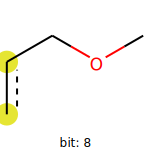

In [65]:
SVG(Draw.DrawRDKitBit(mols[0],8,bitI_rdkit,legend='bit: '+str(bit)))

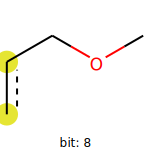

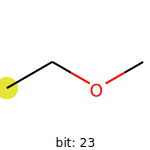

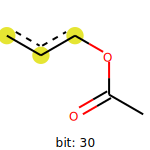

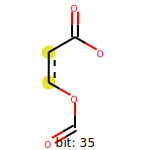

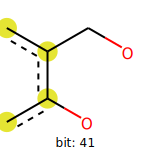

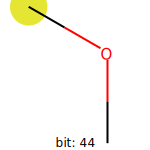

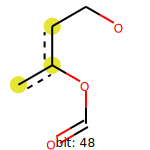

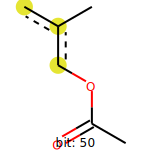

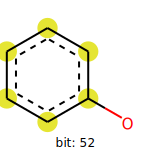

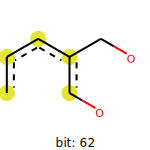

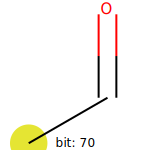

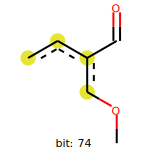

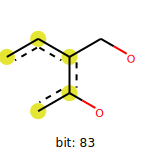

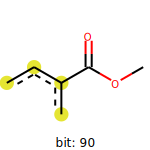

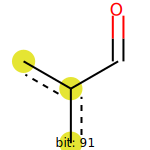

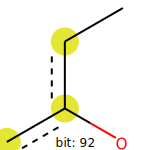

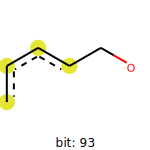

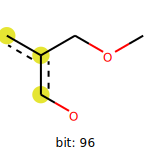

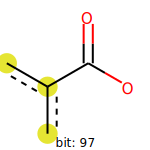

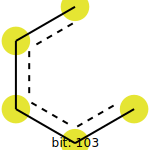

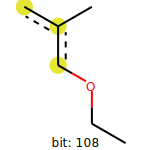

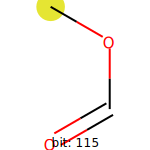

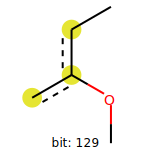

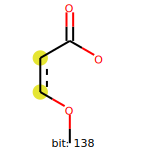

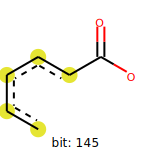

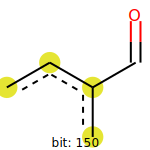

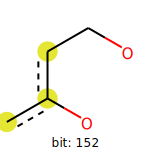

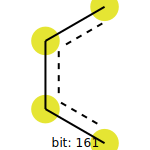

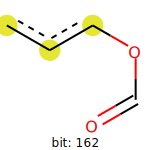

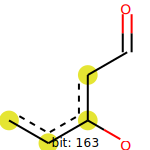

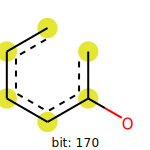

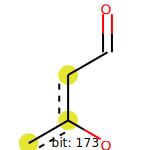

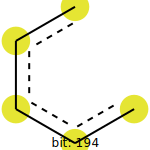

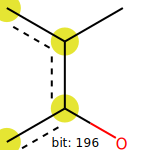

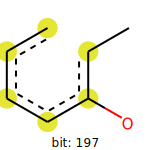

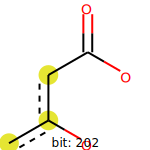

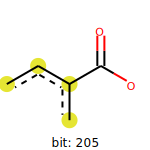

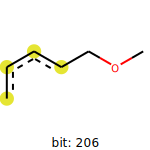

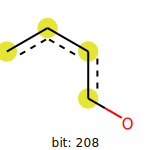

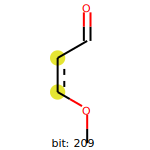

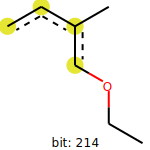

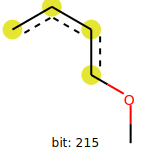

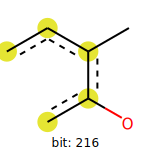

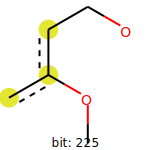

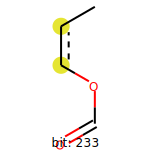

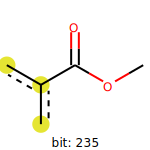

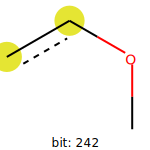

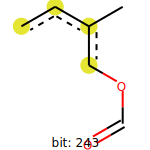

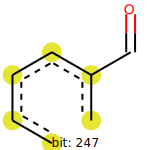

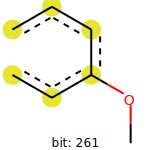

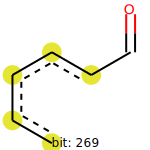

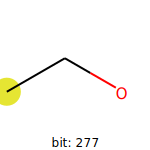

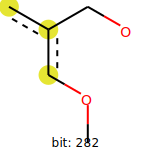

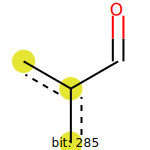

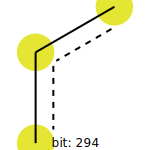

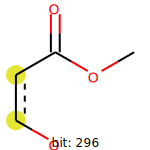

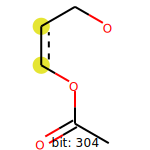

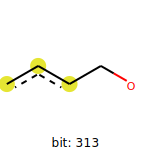

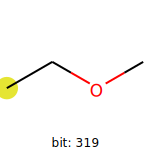

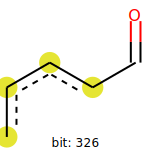

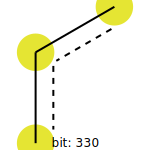

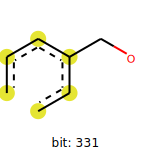

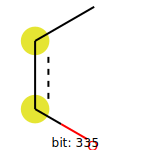

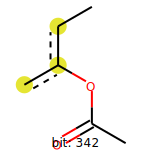

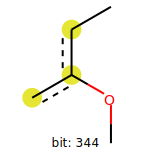

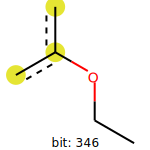

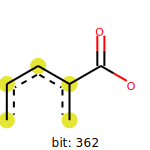

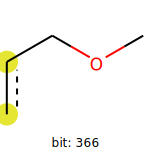

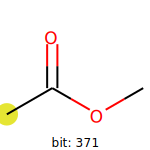

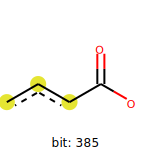

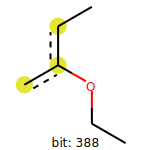

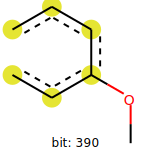

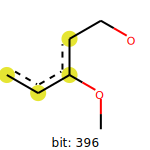

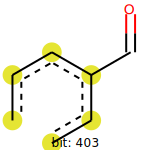

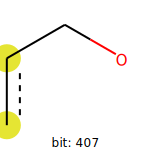

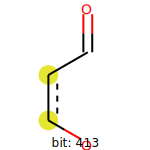

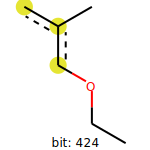

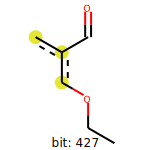

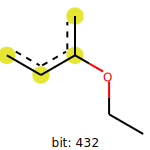

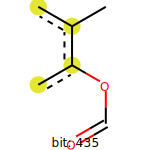

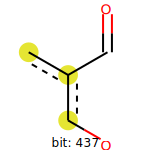

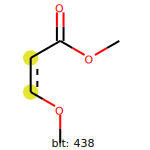

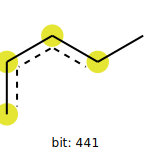

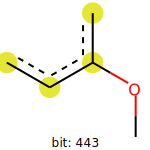

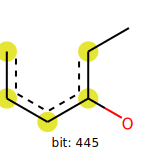

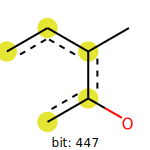

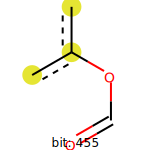

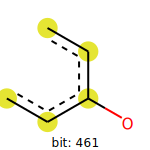

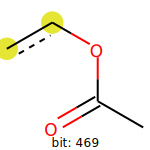

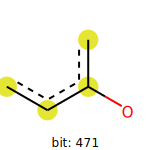

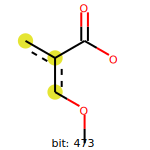

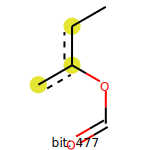

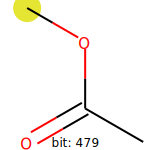

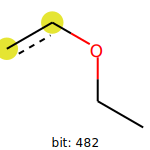

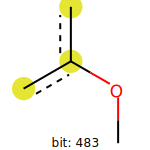

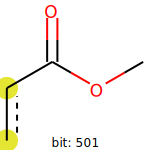

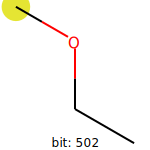

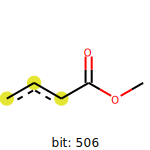

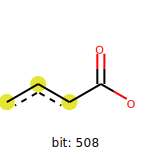

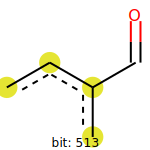

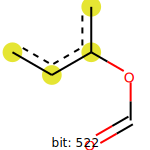

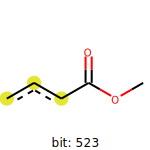

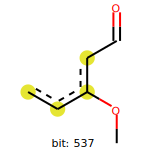

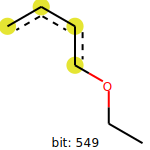

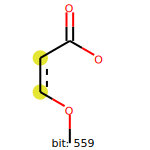

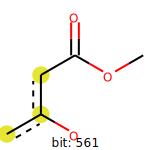

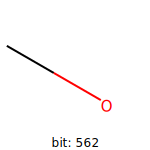

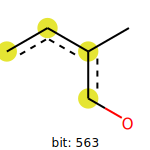

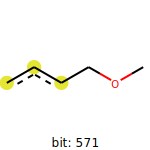

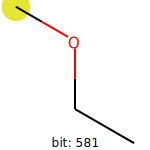

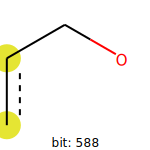

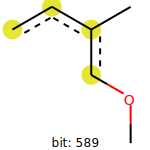

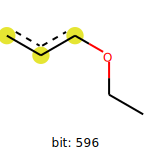

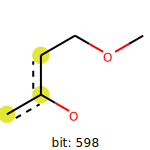

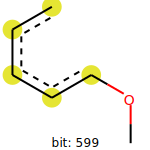

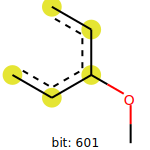

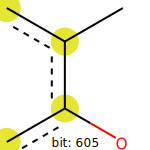

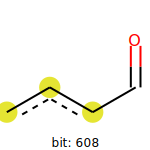

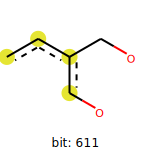

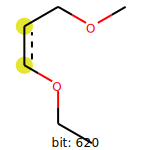

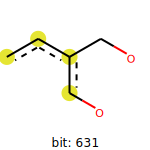

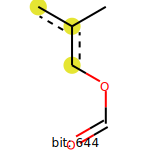

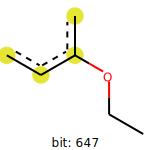

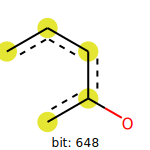

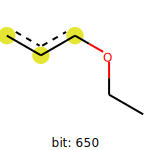

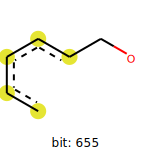

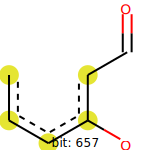

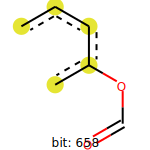

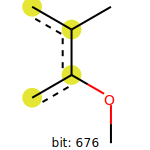

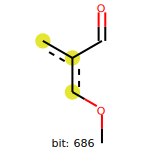

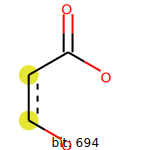

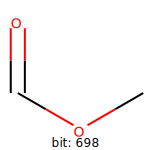

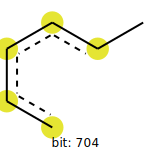

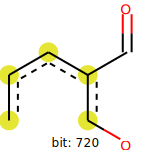

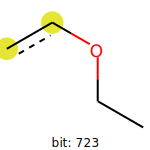

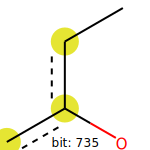

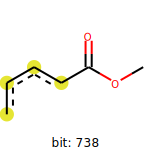

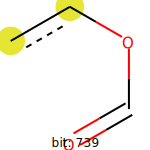

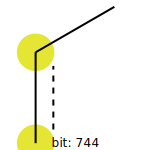

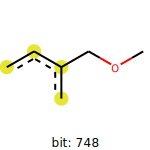

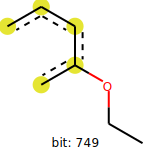

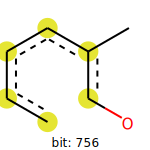

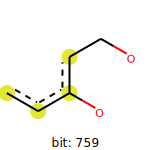

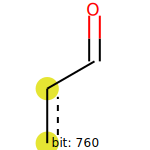

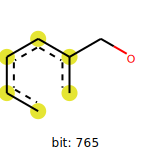

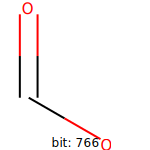

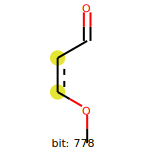

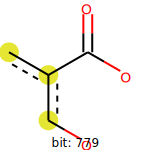

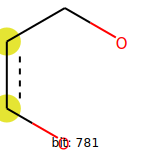

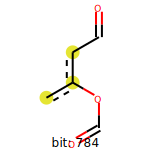

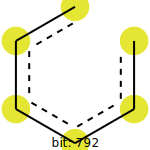

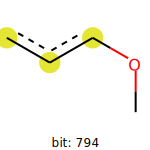

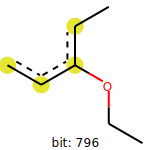

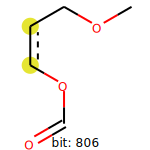

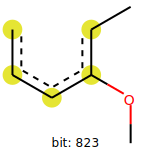

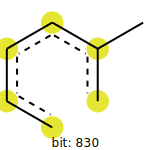

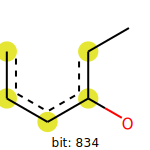

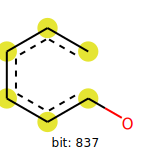

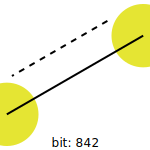

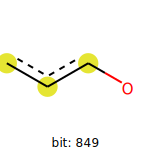

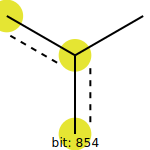

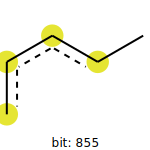

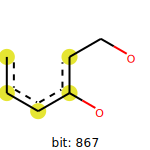

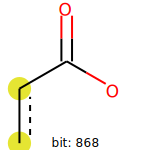

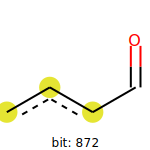

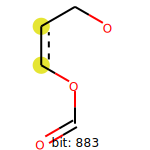

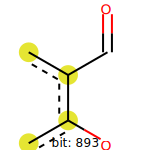

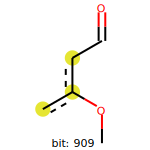

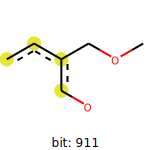

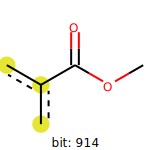

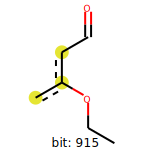

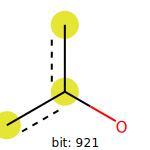

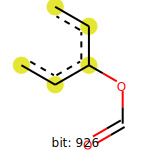

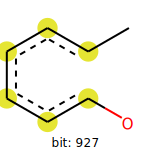

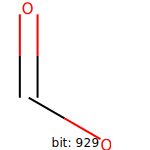

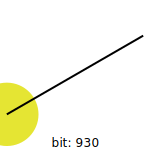

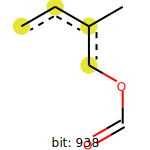

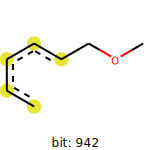

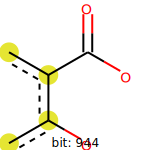

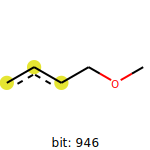

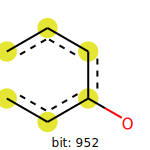

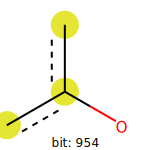

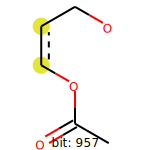

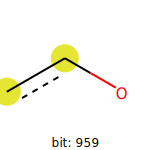

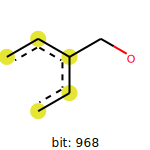

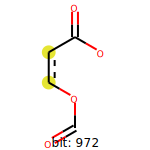

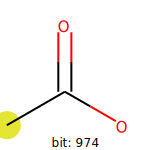

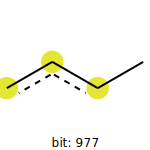

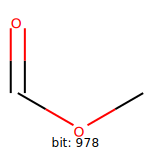

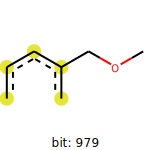

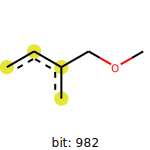

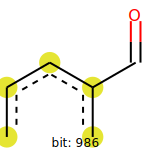

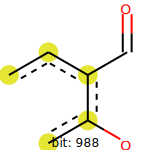

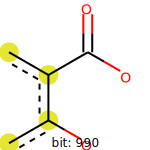

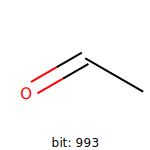

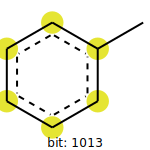

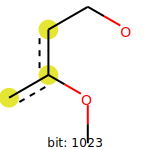

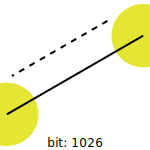

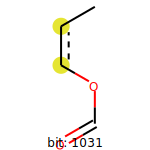

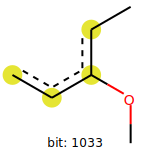

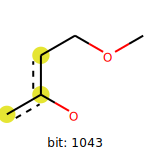

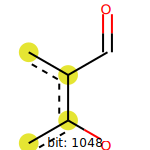

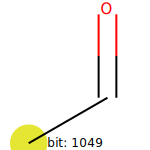

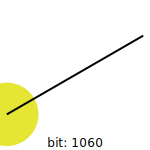

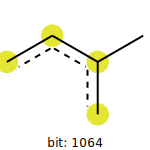

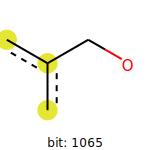

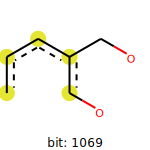

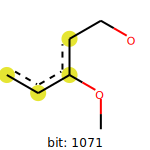

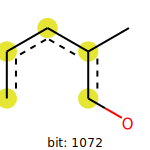

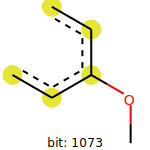

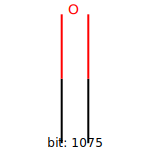

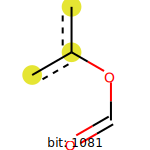

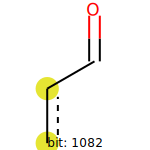

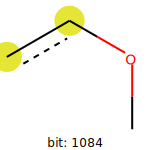

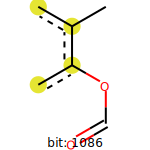

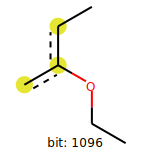

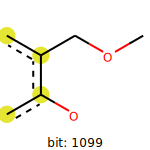

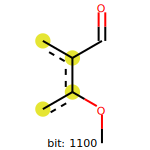

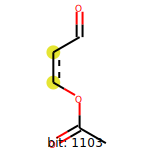

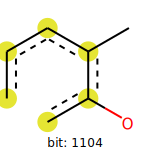

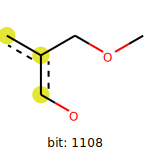

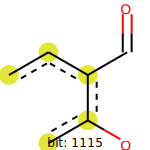

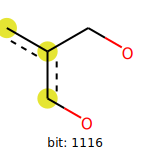

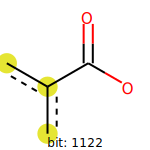

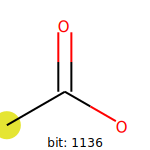

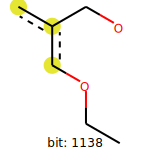

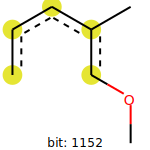

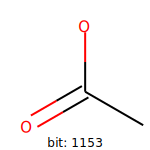

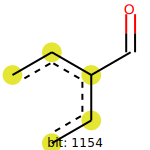

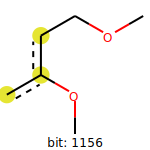

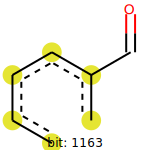

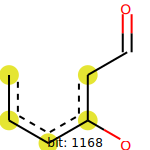

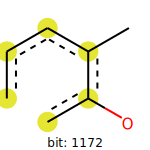

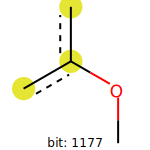

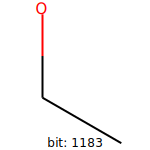

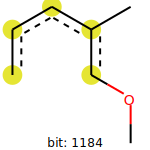

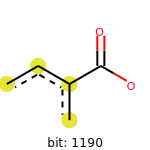

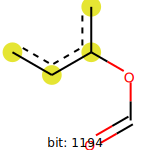

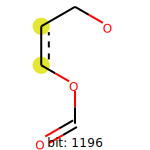

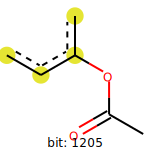

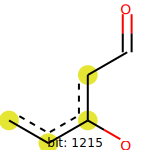

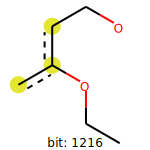

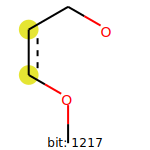

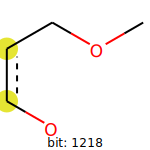

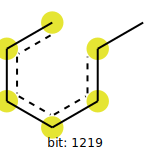

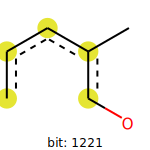

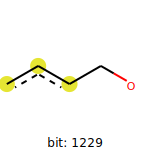

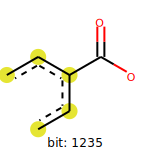

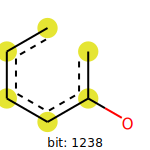

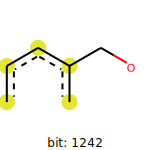

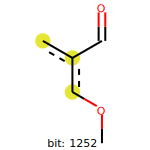

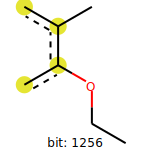

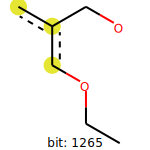

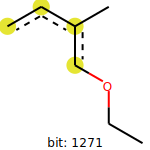

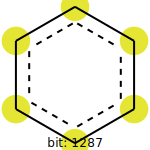

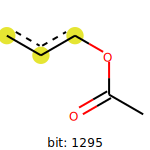

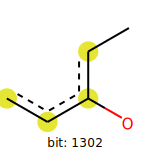

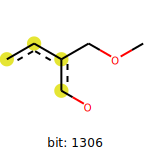

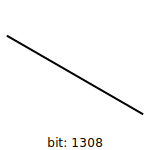

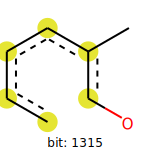

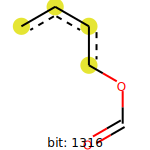

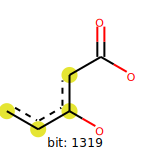

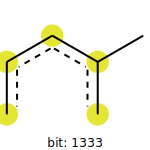

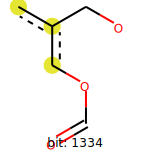

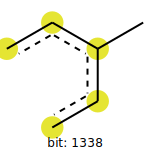

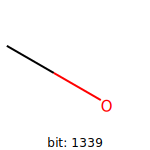

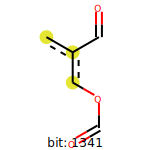

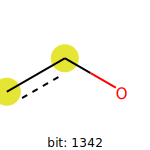

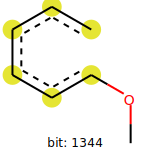

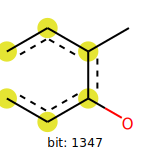

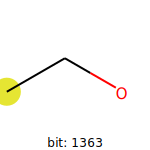

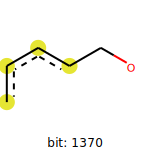

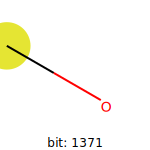

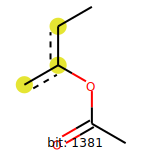

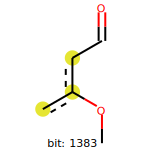

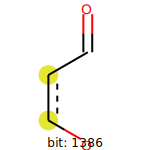

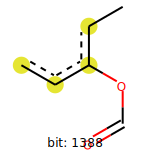

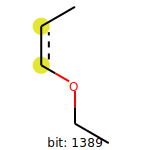

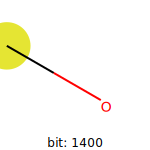

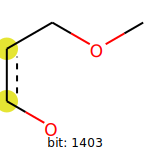

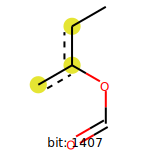

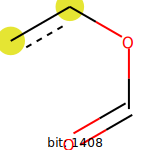

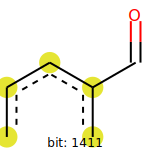

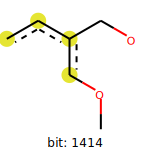

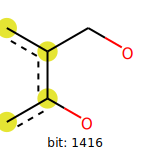

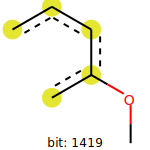

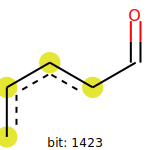

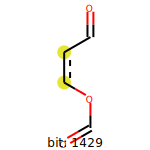

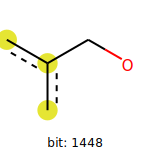

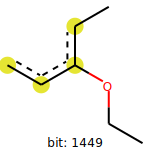

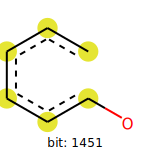

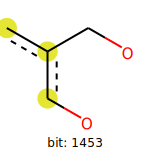

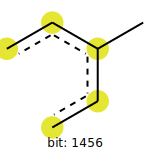

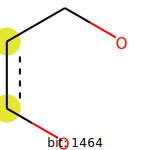

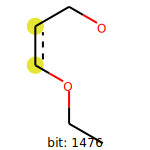

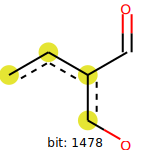

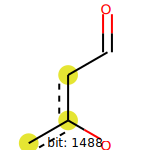

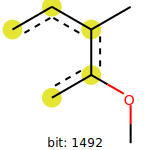

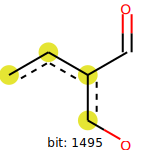

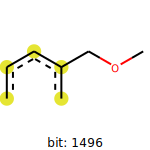

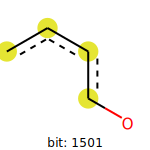

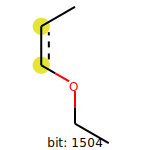

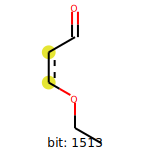

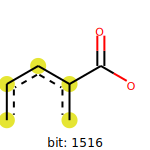

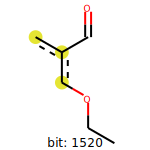

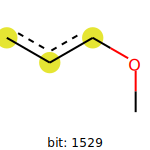

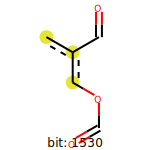

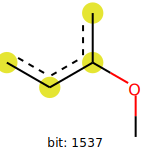

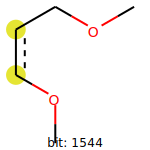

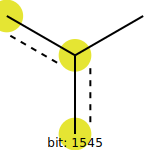

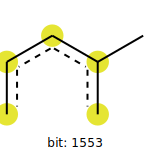

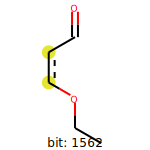

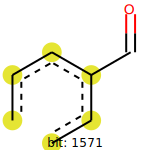

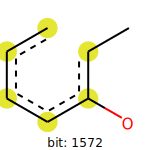

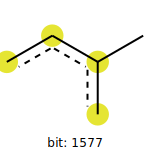

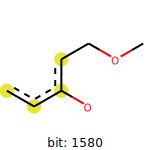

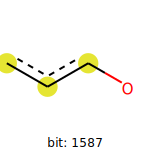

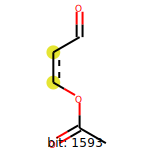

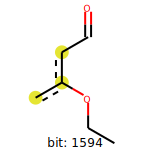

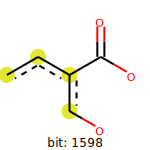

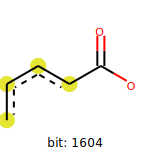

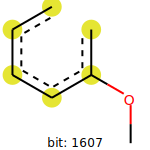

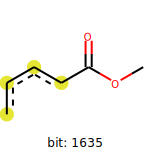

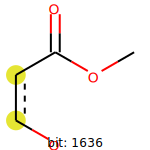

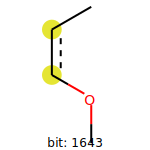

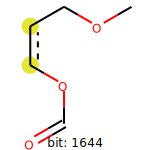

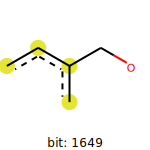

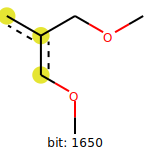

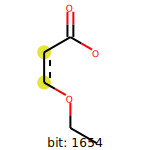

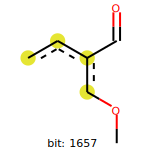

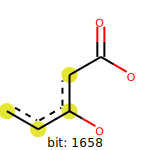

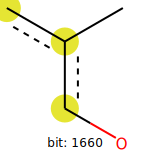

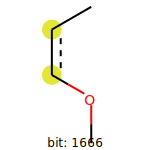

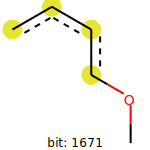

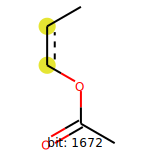

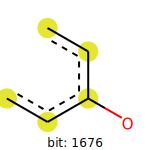

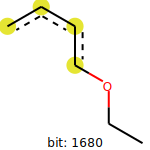

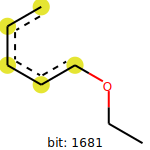

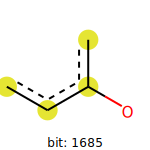

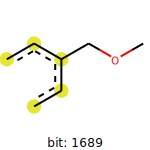

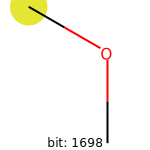

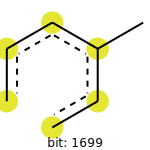

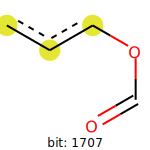

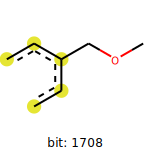

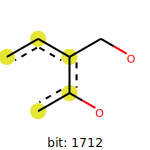

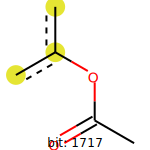

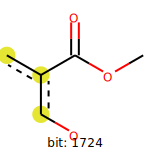

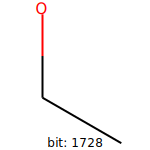

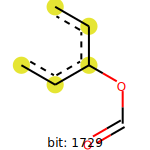

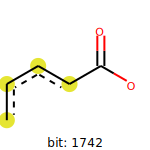

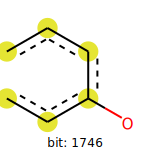

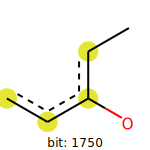

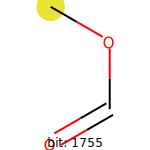

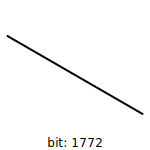

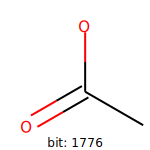

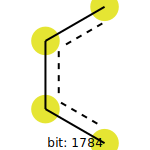

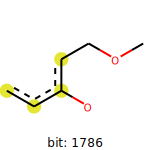

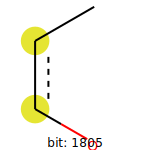

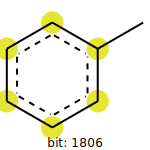

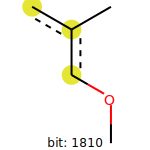

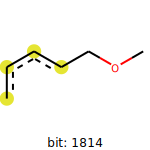

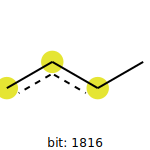

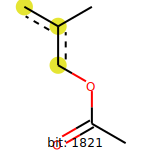

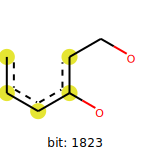

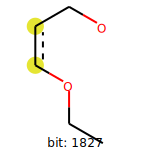

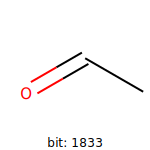

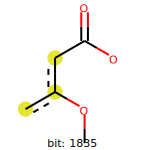

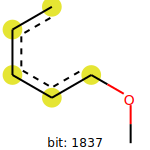

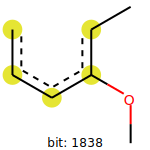

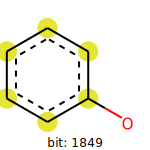

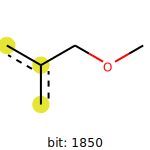

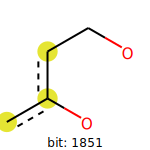

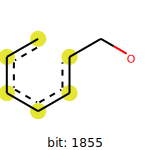

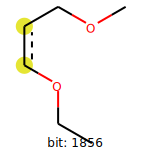

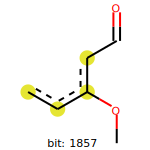

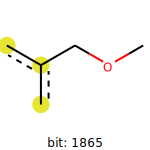

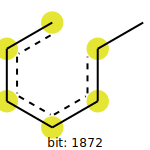

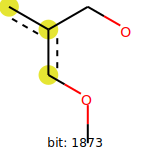

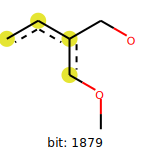

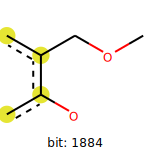

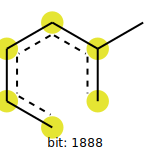

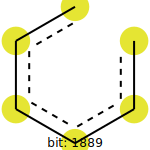

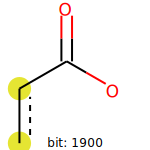

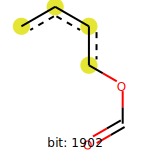

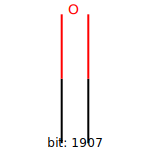

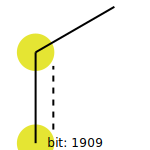

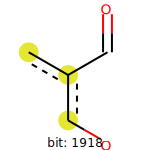

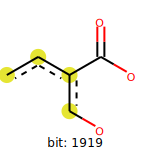

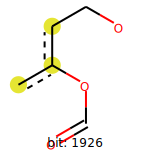

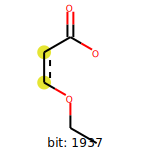

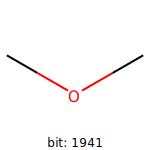

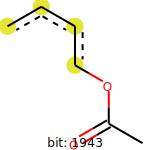

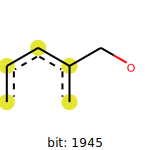

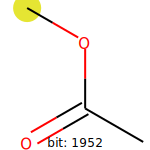

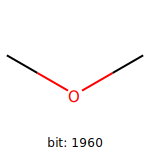

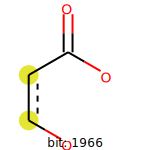

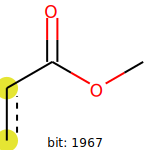

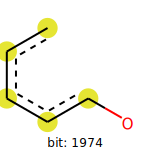

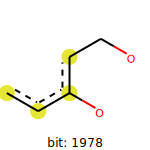

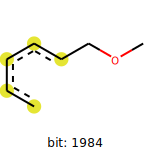

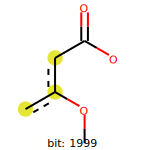

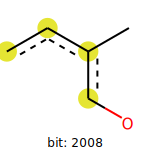

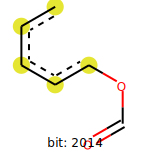

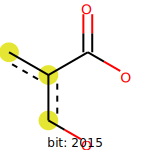

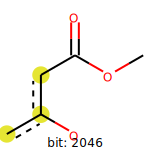

In [67]:
for bit in bitI_rdkit .keys():
    display(SVG(Draw.DrawRDKitBit(mols[0],bit,bitI_rdkit,legend='bit: '+str(bit))))

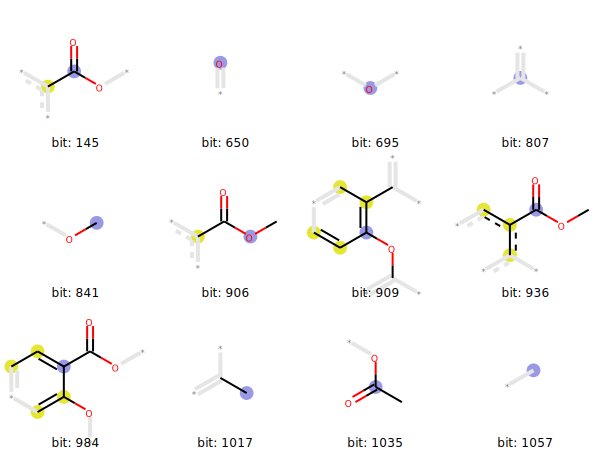

In [28]:
morgan_turples = ((mols[0], bit, bitI_morgan) for bit in list(bitI_morgan.keys())[:12])
SVG(Draw.DrawMorganBits(morgan_turples, molsPerRow=4, legends=['bit: '+str(x) for x in list(bitI_morgan.keys())[:12]]))

In [34]:
SVG(Draw.DrawRDKitBits([(mols[0],52,bitI_rdkit)]))

ValueError: Sanitization error: Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4


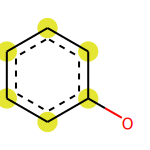

In [33]:
SVG(Draw.DrawRDKitBit(mols[0],52,bitI_rdkit))

In [110]:
list(bitI_rdkit.keys())[8]

52

In [119]:
rdkit_turples =((mols[0], bit, bitI_rdkit) for bit in list(bitI_rdkit.keys())[7:9])

In [121]:
list(bitI_rdkit.keys())[7:9]

[50, 52]

In [157]:
import copy

In [173]:
m=copy.copy(mols[0])

In [174]:
id(mols[0])

140559116910064

In [175]:
id(m)

140559116929904

In [162]:
Chem.Kekulize(m)

In [177]:
rdkit_turples = [(m,52,bitI_rdkit)]

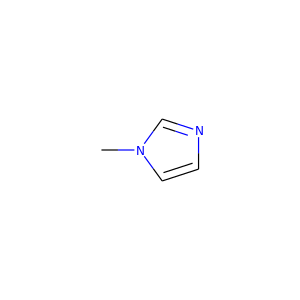

In [41]:
Chem.Draw.MolToImage(mol)

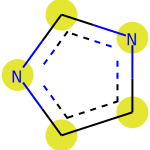

In [54]:
mol = Chem.MolFromSmiles('c1cncn(C)1')
bi = {}
_ = AllChem.RDKFingerprint(mol, minPath=1, maxPath=5, bitInfo=bi)
tuples = [(mol, k, bi) for k in bi.keys()]
SVG(Draw.DrawRDKitBit(mol,1505,bi))

In [55]:
bi[1505]

[[0, 1, 2, 3, 5]]

In [49]:
SVG(Draw.DrawRDKitBits([(mol,1505,bi)]))

ValueError: Sanitization error: Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4


[[0, 1, 2, 3, 5]]

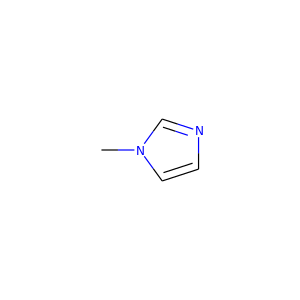

In [38]:
tuples[38]

(<rdkit.Chem.rdchem.Mol at 0x7f44bb285c60>,
 1505,
 {5: [[1, 2], [3, 5]],
  117: [[0, 1, 2, 3, 4]],
  140: [[0, 1, 2, 5], [0, 1, 5, 3]],
  141: [[2, 3, 5, 4]],
  161: [[1, 2], [3, 5]],
  177: [[0, 1, 5, 4, 3]],
  178: [[0, 1, 5, 4]],
  259: [[1, 2, 3, 4]],
  275: [[2, 3, 5, 4]],
  383: [[0, 1, 2, 3], [0, 5, 3, 2]],
  418: [[3, 4], [4, 5]],
  470: [[0, 1, 5]],
  503: [[0, 5, 4]],
  633: [[0, 1], [0, 5]],
  684: [[0, 1], [0, 5]],
  742: [[0, 1, 2], [0, 5, 3]],
  838: [[0, 1, 2], [0, 5, 3]],
  842: [[0]],
  844: [[0, 5, 4]],
  869: [[0, 1, 5, 4, 3]],
  906: [[0, 1, 2, 5, 4]],
  947: [[0, 5, 4, 3, 2]],
  963: [[0, 5, 4, 3, 2]],
  1012: [[1, 2, 3, 5]],
  1013: [[2, 3, 4]],
  1026: [[0]],
  1027: [[1], [2], [3], [5]],
  1060: [[1], [2], [3], [5]],
  1131: [[1, 2, 3, 4]],
  1134: [[0, 1, 2, 5], [0, 1, 5, 3]],
  1177: [[0, 1, 2, 3], [0, 5, 3, 2]],
  1196: [[1, 2, 3, 5]],
  1213: [[1, 2, 3, 5, 4]],
  1256: [[3, 5, 4]],
  1373: [[0, 1, 2, 5, 4]],
  1400: [[0, 5, 4, 3]],
  1422: [[4]],
  1483: [[

In [214]:
e_cause=1505

In [207]:
SVG(Draw.DrawRDKitBits([(mol,1505,bi)]))

ValueError: Sanitization error: Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4


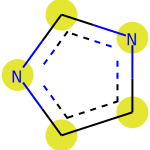

In [208]:
SVG(Draw.DrawRDKitBit(mol,1505,bi))

In [201]:
import inspect

In [212]:
print(inspect.getsource(Draw.DrawRDKitBit))

def DrawRDKitBit(mol, bitId, bitInfo, whichExample=0, **kwargs):
  bondPath = bitInfo[bitId][whichExample]
  return DrawRDKitEnv(mol, bondPath, **kwargs)



In [213]:
print(inspect.getsource(Draw.DrawRDKitBits))

def DrawRDKitBits(tpls, **kwargs):
  envs = []
  for tpl in tpls:
    if len(tpl)==4:
      mol, bitId, bitInfo, whichExample=tpl
    else:
      mol, bitId, bitInfo=tpl
      whichExample=0

    bondpath = bitInfo[bitId][whichExample]
    envs.append((mol, bondpath))
  return DrawRDKitEnvs(envs, **kwargs)



In [220]:
bi[e_cause]

[[0, 1, 2, 3, 5]]

In [221]:
bondpath=bi[e_cause][0]

In [223]:
Draw.DrawRDKitEnvs([(mol,bondpath)])

ValueError: Sanitization error: Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4


In [236]:
print(inspect.getsource(Draw.DrawRDKitEnvs))

def DrawRDKitEnvs(envs, molsPerRow=3, subImgSize=(150, 150), baseRad=0.3, useSVG=True,
                  aromaticColor=(0.9, 0.9, 0.2), extraColor=(0.9, 0.9,0.9),
                  nonAromaticColor=None, legends=None, **kwargs):
  submols = []
  highlightAtoms = []
  atomColors = []
  highlightBonds = []
  bondColors = []
  highlightRadii = []
  for mol, bondpath in envs:
    menv = _getRDKitEnv(mol, bondpath, baseRad, aromaticColor, extraColor, nonAromaticColor,
                        **kwargs)
    submols.append(menv.submol)
    highlightAtoms.append(menv.highlightAtoms)
    atomColors.append(menv.atomColors)
    highlightBonds.append(menv.highlightBonds)
    bondColors.append(menv.bondColors)
    highlightRadii.append(menv.highlightRadii)

  if legends is None:
    legends = [''] * len(envs)

  nRows = len(envs) // molsPerRow
  if len(envs) % molsPerRow:
    nRows += 1

  fullSize = (molsPerRow * subImgSize[0], nRows * subImgSize[1])
  # Drawing
  if useSVG:
    drawer = rdMolDraw2

In [ ]:
def DrawRDKitEnvs(envs, molsPerRow=3, subImgSize=(150, 150), baseRad=0.3, useSVG=True,
                  aromaticColor=(0.9, 0.9, 0.2), extraColor=(0.9, 0.9,0.9),
                  nonAromaticColor=None, legends=None, **kwargs):
    submols = []
    highlightAtoms = []
    atomColors = []
    highlightBonds = []
    bondColors = []
    highlightRadii = []
    for mol, bondpath in envs:
        menv = _getRDKitEnv(mol, bondpath, baseRad, aromaticColor, extraColor, nonAromaticColor,
                            **kwargs)
        submols.append(menv.submol)
        highlightAtoms.append(menv.highlightAtoms)
        atomColors.append(menv.atomColors)
        highlightBonds.append(menv.highlightBonds)
        bondColors.append(menv.bondColors)
        highlightRadii.append(menv.highlightRadii)

    if legends is None:
        legends = [''] * len(envs)

    nRows = len(envs) // molsPerRow
    if len(envs) % molsPerRow:
        nRows += 1

    fullSize = (molsPerRow * subImgSize[0], nRows * subImgSize[1])
    # Drawing
    if useSVG:
    drawer = rdMolDraw2D.MolDraw2DSVG(fullSize[0], fullSize[1], subImgSize[0], subImgSize[1])
    else:
    drawer = rdMolDraw2D.MolDraw2DCairo(fullSize[0], fullSize[1], subImgSize[0], subImgSize[1])

    drawopt = drawer.drawOptions()
    drawopt.continuousHighlight = False
    drawer.DrawMolecules(submols, legends=legends, highlightAtoms=highlightAtoms,
                       highlightAtomColors=atomColors, highlightBonds=highlightBonds,
                       highlightBondColors=bondColors, highlightAtomRadii=highlightRadii, **kwargs)
    drawer.FinishDrawing()
    return drawer.GetDrawingText()

In [234]:
baseRad=0.3
useSVG=True
aromaticColor=(0.9, 0.9, 0.2)
extraColor=(0.9, 0.9,0.9)
nonAromaticColor=None
menv = Draw._getRDKitEnv(mol, bondPath, baseRad, aromaticColor, extraColor, nonAromaticColor)

In [235]:
menv

FingerprintEnv(submol=<rdkit.Chem.rdchem.Mol object at 0x7fd6782a84e0>, highlightAtoms=[0, 1, 2, 3, 4], atomColors={0: (0.9, 0.9, 0.2), 1: (0.9, 0.9, 0.2), 2: (0.9, 0.9, 0.2), 3: (0.9, 0.9, 0.2), 4: (0.9, 0.9, 0.2)}, highlightBonds=[], bondColors={}, highlightRadii={0: 0.3, 1: 0.3, 2: 0.3, 3: 0.3, 4: 0.3})

In [247]:
print(inspect.getsource(Draw.rdMolDraw2D.MolDraw2DSVG))

OSError: source code not available

In [256]:
Draw.DrawRDKitEnv

<function rdkit.Chem.Draw.DrawRDKitEnv(mol, bondPath, molSize=(150, 150), baseRad=0.3, useSVG=True, aromaticColor=(0.9, 0.9, 0.2), extraColor=(0.9, 0.9, 0.9), nonAromaticColor=None, **kwargs)>

In [260]:
inspect.getfile(Draw.rdMolDraw2D)

'/opt/conda/lib/python3.7/site-packages/rdkit/Chem/Draw/rdMolDraw2D.so'

In [249]:
import os

In [262]:
%%bash
cp -f /opt/conda/lib/python3.7/site-packages/rdkit/Chem/Draw/rdMolDraw2D.so ./Draw.rdMolDraw2D.so

In [263]:
%%bash
ls /opt/conda/lib/python3.7/site-packages/rdkit/Chem/Draw/

aggCanvas.py
cairoCanvas.py
canvasbase.py
FreeSans.ttf
__init__.py
IPythonConsole.py
MolDrawing.py
mplCanvas.py
__pycache__
qtCanvas.py
rdMolDraw2D.so
SimilarityMaps.py
spingCanvas.py


In [226]:
def DrawRDKitEnv(mol, bondPath, molSize=(150, 150), baseRad=0.3, useSVG=True,
                 aromaticColor=(0.9, 0.9, 0.2), extraColor=(0.9, 0.9,0.9),
                 nonAromaticColor=None, **kwargs):
    menv = _getRDKitEnv(mol, bondPath, baseRad, aromaticColor, extraColor, nonAromaticColor, **kwargs)

    # Drawing
    if useSVG:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0], molSize[1])
    else:
        drawer = rdMolDraw2D.MolDraw2DCairo(molSize[0], molSize[1])

    drawopt = drawer.drawOptions()
    drawopt.continuousHighlight = False

    drawer.DrawMolecule(menv.submol, highlightAtoms=menv.highlightAtoms,
                      highlightAtomColors=menv.atomColors, highlightBonds=menv.highlightBonds,
                      highlightBondColors=menv.bondColors, highlightAtomRadii=menv.highlightRadii,
                      **kwargs)
    drawer.FinishDrawing()
    return drawer.GetDrawingText()

In [192]:
mol = Chem.MolFromSmiles('c1cncn(C)1')
bondPath = [0, 1, 2, 3, 5]
submol = Chem.PathToSubmol(mol, bondPath)
# submol.UpdatePropertyCache()
# submol.Debug()
Chem.Kekulize(submol)

ValueError: Sanitization error: Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4


In [197]:
Chem.MolToSmiles(submol)

'c1cncn1'

In [178]:
# rdkit_turples =((mols[0], bit, bitI_rdkit) for bit in list(bitI_rdkit.keys())[8:9])
SVG(Draw.DrawRDKitBits(rdkit_turples))

ValueError: Sanitization error: Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4


In [ ]:
Draw.DrawMorganBit(mol[0],0,)

In [48]:
rdkit_fps[0]